In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brats2020-training-data/BraTS20 Training Metadata.csv
/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_337_slice_56.h5
/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_293_slice_67.h5
/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_149_slice_44.h5
/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_109_slice_17.h5
/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_201_slice_137.h5
/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_27_slice_115.h5
/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_128_slice_38.h5
/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_268_slice_18.h5
/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_114_slice_125.h5
/kaggle/input/brats2020-training-data/BraTS2020_

In [2]:
# Import necessary libraries
import os
import h5py
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Sequence
from skimage.transform import resize
import tensorflow.keras.backend as K
import datetime
import json
import matplotlib.pyplot as plt

# -------------------------------
# 1. Verify GPU Availability
# -------------------------------
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Available GPU devices:", tf.config.list_physical_devices('GPU'))

# -------------------------------
# 2. Define Custom Metrics
# -------------------------------
def dice_coefficient(y_true, y_pred, smooth=1):
    """
    Calculates the Dice Coefficient.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1):
    """
    Calculates the Intersection over Union (IoU) metric.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# -------------------------------
# 3. Define the U-Net Model
# -------------------------------
def unet_model(input_size=(128, 128, 4)):
    inputs = Input(input_size)

    # Encoding path
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2, 2))(c4)

    # Bottleneck
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    # Decoding path
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# -------------------------------
# 4. Prepare the Data
# -------------------------------

# Define the data directory (adjust this path if necessary)
data_dir = '/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data'

# Get list of .h5 files
h5_files = [f for f in os.listdir(data_dir) if f.endswith('.h5')]

# Ensure that there are .h5 files in the directory
if not h5_files:
    raise FileNotFoundError(f"No .h5 files found in the directory: {data_dir}")

# Split into training and validation sets
train_files, val_files = train_test_split(h5_files, test_size=0.2, random_state=42)

print(f"Total samples: {len(h5_files)}")
print(f"Training samples: {len(train_files)}")
print(f"Validation samples: {len(val_files)}")

# Parameters
batch_size = 8  # Adjust based on GPU memory
image_dim = (128, 128)  # Adjust based on your image dimensions

# -------------------------------
# 5. Define the Data Generator
# -------------------------------
class DataGenerator(Sequence):
    def __init__(self, h5_files, data_dir, batch_size=16, dim=(128, 128), shuffle=True):
        self.h5_files = h5_files
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.h5_files))
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.h5_files) / self.batch_size))
        
    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        h5_batch = [self.h5_files[k] for k in batch_indexes]
        X, y = self.__data_generation(h5_batch)
        return X, y
        
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
        
    def __data_generation(self, h5_batch):
        # Initialize arrays
        X = np.empty((self.batch_size, *self.dim, 4), dtype='float32')  # 4 channels
        y = np.empty((self.batch_size, *self.dim, 1), dtype='float32')  # Single-channel masks
            
        for i, h5_file in enumerate(h5_batch):
            file_path = os.path.join(self.data_dir, h5_file)
            with h5py.File(file_path, 'r') as hf:
                # Check for the correct keys
                if 'image' in hf.keys() and 'mask' in hf.keys():
                    image = hf['image'][:]  # Expected shape: (H, W, 4)
                    mask = hf['mask'][:]    # Expected shape: (H, W) or (H, W, C)
                else:
                    raise KeyError(f"Unexpected keys in {h5_file}: {list(hf.keys())}")

                # If mask has multiple channels, convert to single-channel
                if mask.ndim > 2:
                    mask = np.mean(mask, axis=-1)  # Example: Convert RGB to grayscale

                # Resize images if necessary
                if image.shape[:2] != self.dim:
                    image = resize(
                        image, 
                        (*self.dim, image.shape[2]), 
                        preserve_range=True, 
                        anti_aliasing=True
                    )
                
                if mask.shape != self.dim:
                    # Use nearest-neighbor interpolation for masks to preserve labels
                    mask = resize(
                        mask, 
                        self.dim, 
                        preserve_range=True, 
                        order=0, 
                        anti_aliasing=False
                    )

                # Normalize the image
                image_max = np.max(image)
                if image_max > 0:
                    image = image.astype('float32') / image_max
                else:
                    image = image.astype('float32')

                # Normalize the mask
                mask_max = np.max(mask)
                if mask_max > 0:
                    mask = mask.astype('float32') / mask_max
                else:
                    mask = mask.astype('float32')  # All zeros

                # Assign to batch arrays
                X[i] = image  # Shape: (128, 128, 4)
                y[i] = np.expand_dims(mask, axis=-1)  # Shape: (128, 128, 1)
            
        return X, y

# -------------------------------
# 6. Instantiate Data Generators
# -------------------------------
training_generator = DataGenerator(train_files, data_dir, batch_size=batch_size, dim=image_dim, shuffle=True)
validation_generator = DataGenerator(val_files, data_dir, batch_size=batch_size, dim=image_dim, shuffle=False)

# -------------------------------
# 7. Build and Compile the Model
# -------------------------------
model = unet_model(input_size=(*image_dim, 4))  # Updated input size
model.compile(optimizer=Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, iou_metric])
model.summary()

# -------------------------------
# 8. Define Callbacks
# -------------------------------
# Create a timestamp for the logs
log_dir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# TensorBoard callback for visualization
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# EarlyStopping callback with multiple metric monitoring
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    restore_best_weights=True
)

# ModelCheckpoint callback to save the best model with '.keras' extension
model_checkpoint = ModelCheckpoint(
    'model-unet.best.keras',  # Changed from '.h5' to '.keras'
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    mode='min'
)

# Combine all callbacks
callbacks = [
    early_stopping,
    model_checkpoint,
    tensorboard_callback
]

# -------------------------------
# 9. Train the Model
# -------------------------------
epochs = 2  # You can adjust this based on your requirements

try:
    results = model.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1  # Set to 1 for progress bar, 2 for one line per epoch, 0 for silent
    )
except Exception as e:
    print(f"An error occurred during training: {e}")

# -------------------------------
# 10. Save the Final Model (Optional)
# -------------------------------
model.save('final_model_unet.keras')
print("Model training complete and saved as 'final_model_unet.keras'.")

# -------------------------------
# 11. Save Training History
# -------------------------------
# Save the training history to a JSON file
with open('training_history.json', 'w') as f:
    json.dump(results.history, f)
print("Training history saved as 'training_history.json'.")

# -------------------------------
# 12. Plot Training History
# -------------------------------
def plot_training_history(history, metrics=['loss', 'accuracy', 'dice_coefficient', 'iou_metric']):
    """
    Plots training and validation metrics over epochs.
    """
    for metric in metrics:
        plt.figure(figsize=(8, 6))
        plt.plot(history[metric], label=f'Training {metric}')
        plt.plot(history[f'val_{metric}'], label=f'Validation {metric}')
        plt.title(f'Training and Validation {metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.savefig(f'{metric}_plot.png')
        plt.close()
        print(f"{metric.capitalize()} plot saved as '{metric}_plot.png'.")

# Plot and save the training history
plot_training_history(results.history)

# -------------------------------
# 13. Launch TensorBoard (Optional)
# -------------------------------
# Note: To visualize TensorBoard logs, run the following command in your terminal:
# tensorboard --logdir=logs

#print(f"TensorBoard logs are saved in '{log_dir}'. To visualize, run 'tensorboard --logdir={log_dir}' in your terminal.")

# -------------------------------
# 14. Visualize Results
# -------------------------------
def visualize_predictions(generator, model, num_samples=5):
    """
    Visualizes predictions of the model on a few samples.
    """
    samples_visualized = 0
    for X_batch, y_true_batch in generator:
        # Predict the batch
        y_pred_batch = model.predict(X_batch)
        
        for i in range(len(X_batch)):
            if samples_visualized >= num_samples:
                return  # Stop after visualizing the requested number of samples
            
            input_image = X_batch[i]
            true_mask = y_true_batch[i].squeeze()  # Remove single channel
            pred_mask = y_pred_batch[i].squeeze()  # Remove single channel
            
            # Plot input image, true mask, and predicted mask
            plt.figure(figsize=(12, 6))
            
            # Original Input Image
            plt.subplot(1, 3, 1)
            plt.imshow(input_image[..., 0], cmap='gray')  # Show only one channel
            plt.title('Input Image (Channel 0)')
            plt.axis('off')
            
            # True Mask
            plt.subplot(1, 3, 2)
            plt.imshow(true_mask, cmap='gray')
            plt.title('True Mask')
            plt.axis('off')
            
            # Predicted Mask
            plt.subplot(1, 3, 3)
            plt.imshow(pred_mask, cmap='gray')
            plt.title('Predicted Mask')
            plt.axis('off')
            
            # Save or show the plot
            plt.savefig(f'sample_visualization_{samples_visualized + 1}.png')
            plt.close()
            
            print(f"Visualization for sample {samples_visualized + 1} saved as 'sample_visualization_{samples_visualized + 1}.png'")
            samples_visualized += 1

# Visualize predictions on the validation set
print("Visualizing predictions on the validation set...")
visualize_predictions(validation_generator, model, num_samples=5)

2025-05-17 16:57:49.477853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747501069.668136      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747501069.723511      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1
Available GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Total samples: 57195
Training samples: 45756
Validation samples: 11439


I0000 00:00:1747501082.400697      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 4)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 128, 128, 64)   │          2,368 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 64, 64, 128)    │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 32, 32, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 16, 16, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 8, 8, 512)      │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 8, 8, 1024)     │      4,719,616 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 8, 8, 1024)     │      9,438,208 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 512)    │      2,097,664 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 16, 16, 1024)   │              0 │ conv2d_transpose[0][0… │
│                      

 Total params: 31,032,321 (118.38 MB)

 Trainable params: 31,032,321 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 4))
  warnings.warn(msg)
I0000 00:00:1747501093.642476      97 service.cc:148] XLA service 0x7acc3c003150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747501093.643173      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747501094.621371      97 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747501104.799301      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5719/5719 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9935 - dice_coefficient: 0.5333 - iou_metric: 0.3989 - loss: 0.0340

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 128, 128, 4))
  warnings.warn(msg)



Epoch 1: val_loss improved from inf to 0.00906, saving model to model-unet.best.keras
5719/5719 ━━━━━━━━━━━━━━━━━━━━ 1642s 284ms/step - accuracy: 0.9935 - dice_coefficient: 0.5333 - iou_metric: 0.3989 - loss: 0.0340 - val_accuracy: 0.9967 - val_dice_coefficient: 0.7048 - val_iou_metric: 0.5669 - val_loss: 0.0091
Epoch 2/2
5719/5719 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9970 - dice_coefficient: 0.7416 - iou_metric: 0.6124 - loss: 0.0084
Epoch 2: val_loss improved from 0.00906 to 0.00656, saving model to model-unet.best.keras
5719/5719 ━━━━━━━━━━━━━━━━━━━━ 1408s 246ms/step - accuracy: 0.9970 - dice_coefficient: 0.7416 - iou_metric: 0.6124 - loss: 0.0084 - val_accuracy: 0.9976 - val_dice_coefficient: 0.8002 - val_iou_metric: 0.6887 - val_loss: 0.0066
Restoring model weights from the end of the best epoch: 2.
Model training complete and saved as 'final_model_unet.keras'.
Training history saved as 'training_history.json'.
Loss plot saved as 'loss_plot.png'.
Accuracy plot saved a

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(8, 128, 128, 4))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 910ms/step
Visualization for sample 1 saved as 'sample_visualization_1.png'
Visualization for sample 2 saved as 'sample_visualization_2.png'
Visualization for sample 3 saved as 'sample_visualization_3.png'
Visualization for sample 4 saved as 'sample_visualization_4.png'
Visualization for sample 5 saved as 'sample_visualization_5.png'


In [3]:
import os

working_dir = '/kaggle/working'
print("Files in working directory:", os.listdir(working_dir))

Files in working directory: ['sample_visualization_1.png', 'iou_metric_plot.png', 'logs', 'model-unet.best.keras', 'sample_visualization_5.png', 'accuracy_plot.png', 'sample_visualization_2.png', 'loss_plot.png', 'final_model_unet.keras', 'sample_visualization_4.png', '.virtual_documents', 'dice_coefficient_plot.png', 'sample_visualization_3.png', 'training_history.json']


In [4]:
from tensorflow.keras.models import load_model

# Define the file path (adjust if necessary)
model_path = '/kaggle/working/final_model_unet.keras'

# Load the model with custom objects
model = load_model(model_path, custom_objects={
    'dice_coefficient': dice_coefficient,
    'iou_metric': iou_metric
})

print("Model loaded successfully!")

Model loaded successfully!


In [7]:
def preprocess_image(file_path, image_dim=(128, 128)):
    """
    Loads and preprocesses an image and its corresponding mask from an h5 file.
    """
    with h5py.File(file_path, 'r') as hf:
        # Check for 'image' and 'mask' keys
        if 'image' in hf.keys() and 'mask' in hf.keys():
            image = hf['image'][:]  # Shape: (H, W, 4)
            mask = hf['mask'][:]    # Shape: (H, W)
        else:
            raise KeyError(f"Unexpected keys in {file_path}: {list(hf.keys())}")

        # Print mask statistics for debugging
        print(f"Mask stats for {file_path}: min={mask.min()}, max={mask.max()}, mean={mask.mean()}")

        # Resize the image and mask to match the model's input dimensions
        if image.shape[:2] != image_dim:
            image = resize(image, (*image_dim, image.shape[2]), preserve_range=True, anti_aliasing=True)
        if mask.shape[:2] != image_dim:
            mask = resize(mask, image_dim, preserve_range=True, order=0, anti_aliasing=False)

        # Normalize the image
        image_max = np.max(image)
        if image_max > 0:
            image = image.astype('float32') / image_max

        # Normalize the mask to range [0, 1] for visualization
        mask = np.expand_dims((mask - mask.min()) / (mask.max() - mask.min() + 1e-8), axis=-1)

    return image, mask

Mask stats for /kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_100_slice_100.h5: min=0, max=1, mean=0.0064293981481481485
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


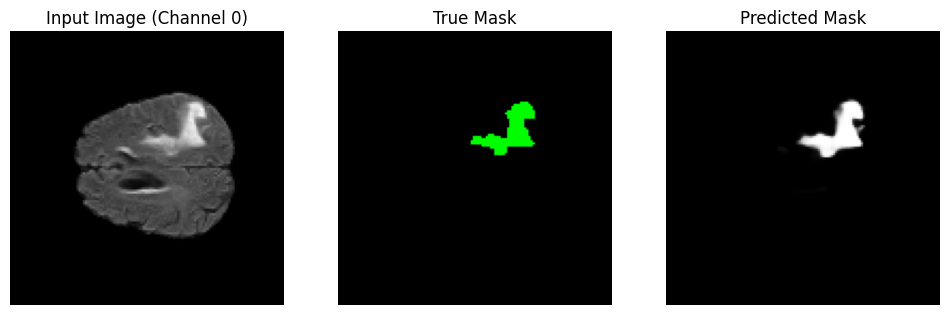

In [8]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize

# -------------------------------
# Visualize Predictions
# -------------------------------
def predict_and_visualize(file_paths, model, image_dim=(128, 128)):
    """
    Loads and preprocesses images from file paths, predicts their outputs, and visualizes results.
    """
    for i, file_path in enumerate(file_paths):
        # Load and preprocess the image and mask
        image, true_mask = preprocess_image(file_path, image_dim)

        # Predict the mask using the model
        pred_mask = model.predict(np.expand_dims(image, axis=0))[0]  # Add batch dimension, then remove it

        # Visualize the input image, true mask, and predicted mask
        plt.figure(figsize=(12, 6))

        # Original Input Image
        plt.subplot(1, 3, 1)
        plt.imshow(image[..., 0], cmap='gray')  # Display the first channel
        plt.title('Input Image (Channel 0)')
        plt.axis('off')

        # True Mask
        plt.subplot(1, 3, 2)
        plt.imshow(true_mask.squeeze(), cmap='gray')  # Remove the channel dimension for display
        plt.title('True Mask')
        plt.axis('off')

        # Predicted Mask
        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap='gray')  # Remove the channel dimension for display
        plt.title('Predicted Mask')
        plt.axis('off')

        # Show the plot directly
        plt.show()

# -------------------------------
# Specify the File Paths
# -------------------------------
data_dir = '/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data'
files_to_predict = [
    "/kaggle/input/brats2020-training-data/BraTS2020_training_data/content/data/volume_100_slice_100.h5"
    
]

# -------------------------------
# Predict and Visualize
# -------------------------------
predict_and_visualize(files_to_predict, model)

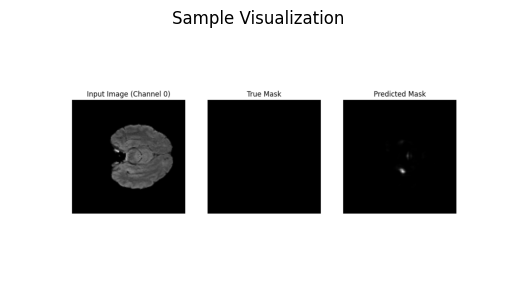

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('/kaggle/working/sample_visualization_1.png')
plt.imshow(img)
plt.axis('off')
plt.title("Sample Visualization")
plt.show()

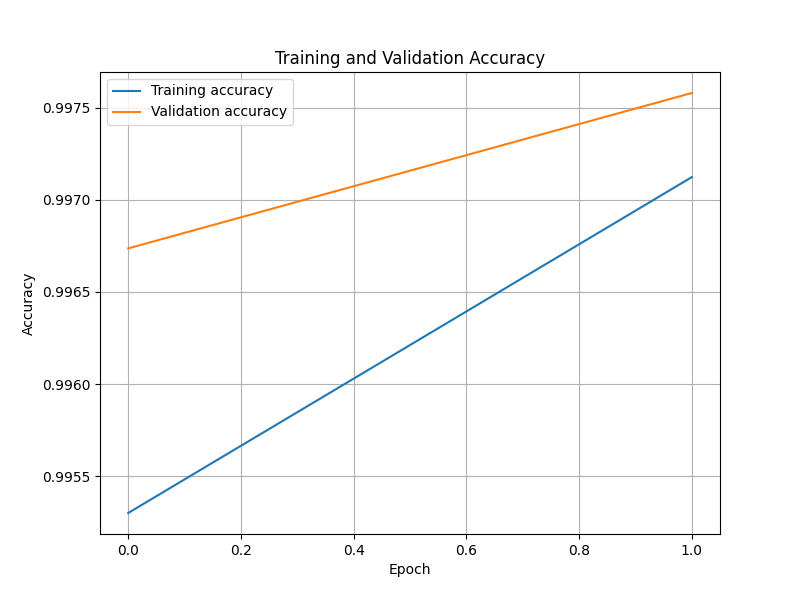

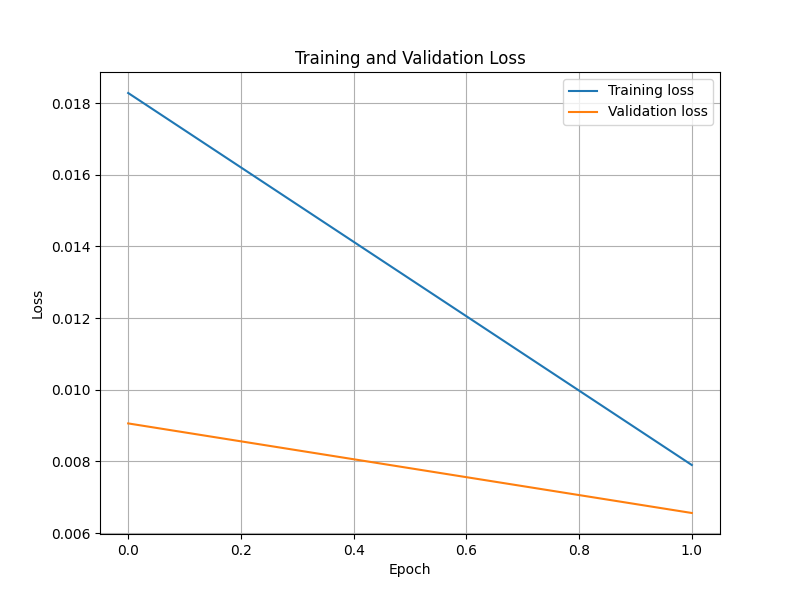

In [10]:
from IPython.display import Image, display

display(Image('/kaggle/working/accuracy_plot.png'))
display(Image('/kaggle/working/loss_plot.png'))

In [11]:
import os

print(os.path.exists('/kaggle/working/final_model_unet.keras'))  # Should print True

True
